In [ ]:
!nvidia-smi


Tue Oct 14 02:54:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change this to your dataset folder path inside Drive
dataset_path = "/content/drive/MyDrive/chest_xray"

train_dir = dataset_path + "/train"
val_dir   = dataset_path + "/val"
test_dir  = dataset_path + "/test"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive


 ai_project  'archive (1).zip'	'Colab Notebooks'


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/archive (1).zip"
extract_path = "/content/drive/MyDrive/ai_project"

# Extract if not already done
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Extracted dataset!")
else:
    print("⚡ Dataset already extracted")


⚡ Dataset already extracted


In [ ]:
!ls "/content/drive/MyDrive/ai_project"


best_vgg16_augmented.h5  best_vgg16.h5	chest_xray


In [ ]:
!ls "/content/drive/MyDrive/ai_project/chest_xray"


test  train  val


In [ ]:
import shutil, os

# Paths to delete
folders_to_delete = [
    "/content/drive/MyDrive/ai_project/chest_xray/chest_xray",
    "/content/drive/MyDrive/ai_project/chest_xray/__MACOSX"
]

for folder in folders_to_delete:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Deleted: {folder}")
    else:
        print(f"Not found (already deleted): {folder}")


Not found (already deleted): /content/drive/MyDrive/ai_project/chest_xray/chest_xray
Not found (already deleted): /content/drive/MyDrive/ai_project/chest_xray/__MACOSX


In [ ]:
!ls "/content/drive/MyDrive/ai_project/chest_xray"

test  train  val


In [ ]:
!ls "/content/drive/MyDrive/ai_project/chest_xray/train"


NORMAL	PNEUMONIA


In [ ]:
!ls "/content/drive/MyDrive/ai_project/chest_xray/test"


NORMAL	PNEUMONIA


In [ ]:
!ls "/content/drive/MyDrive/ai_project/chest_xray/val"


NORMAL	PNEUMONIA


In [ ]:
dataset_path = "/content/drive/MyDrive/ai_project"


In [ ]:
import os

base_path = "/content/drive/MyDrive/ai_project/chest_xray"

for split in ["train", "val", "test"]:
    print(f"\n📂 {split.upper()} set:")
    for cls in os.listdir(os.path.join(base_path, split)):
        cls_path = os.path.join(base_path, split, cls)
        print(f"{cls}: {len(os.listdir(cls_path))} images")



📂 TRAIN set:
NORMAL: 1341 images
PNEUMONIA: 3875 images

📂 VAL set:
NORMAL: 8 images
PNEUMONIA: 8 images

📂 TEST set:
NORMAL: 234 images
PNEUMONIA: 390 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(base_path, "val"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(base_path, "test"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1   # <-- 10% training data used as validation
)

# Train generator (90%)
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation generator (10%)
val_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Test stays the same
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_path, "test"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import os

base_path = "/content/drive/MyDrive/ai_project/chest_xray"  # change if different

for split in ["train", "val", "test"]:
    print(f"\n--- {split.upper()} ---")
    for cls in os.listdir(os.path.join(base_path, split)):
        cls_path = os.path.join(base_path, split, cls)
        print(f"{cls}: {len(os.listdir(cls_path))} images")



--- TRAIN ---
NORMAL: 1341 images
PNEUMONIA: 3875 images

--- VAL ---
NORMAL: 8 images
PNEUMONIA: 8 images

--- TEST ---
NORMAL: 234 images
PNEUMONIA: 390 images


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_path = "/content/drive/MyDrive/ai_project/chest_xray"

# ImageDataGenerator with more aggressive augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.2, # Increased shift
    height_shift_range=0.2, # Increased shift
    shear_range=0.2,      # Increased shear
    zoom_range=0.2,       # Increased zoom
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of training images used for validation
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, "train"),
    target_size=(150, 150),   # you can change size if needed
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Validation generator (only rescaling, no augmentation)
# We will use a separate datagen for validation to avoid augmenting validation data
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = val_datagen.flow_from_directory(
    os.path.join(base_path, "train"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation' # Use the validation subset from the original training data
)


# Test generator (only rescaling, no split)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    os.path.join(base_path, "test"),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print("Number of training images:", train_gen.samples)
print("Number of validation images:", val_gen.samples)
print("Number of test images:", test_gen.samples)


Number of training images: 4173
Number of validation images: 1043
Number of test images: 624


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Load VGG16 without top classifier layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(150,150,3))

# Freeze base model layers so we don’t retrain them initially
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/ai_project/best_vgg16.h5",
    monitor="val_loss", save_best_only=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
)

# Class weights (helps with NORMAL vs PNEUMONIA imbalance)
# train_gen is your generator with subset='training'
classes = np.unique(train_gen.classes)        # e.g., [0, 1]
cw = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_gen.classes
)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
class_weight


{0: 1.9445479962721341, 1: 0.6730645161290323}

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, ckpt, reduce_lr],
    class_weight=class_weight,      # you can remove this line if you don’t want weighting
    verbose=1
)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8778 - loss: 0.2927

131/131 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8779 - loss: 0.2924 - val_accuracy: 0.7728 - val_loss: 0.4919 - learning_rate: 1.0000e-04
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.9047 - loss: 0.2400

131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 670ms/step - accuracy: 0.9047 - loss: 0.2400 - val_accuracy: 0.8591 - val_loss: 0.3224 - learning_rate: 1.0000e-04
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 662ms/step - accuracy: 0.9137 - loss: 0.2229 - val_accuracy: 0.8332 - val_loss: 0.3784 - learning_rate: 1.0000e-04
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 644ms/step - accuracy: 0.9222 - loss: 0.2102 - val_accuracy: 0.8130 - val_loss: 0.4420 - learning_rate: 1.0000e-04
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 639ms/step - accuracy: 0.9106 - loss: 0.2100 - val_accuracy: 0.8236 - val_loss: 0.4264 - learning_rate: 5.0000e-05


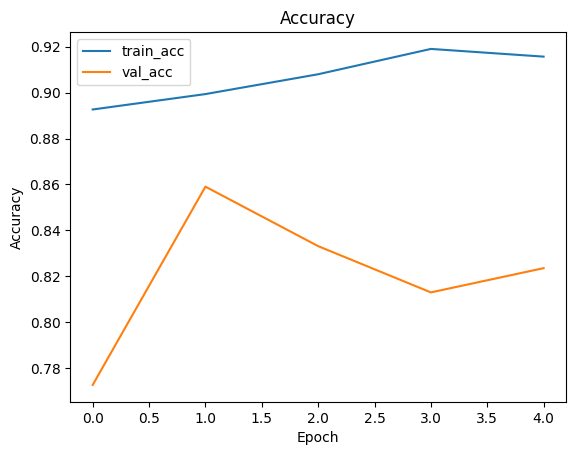

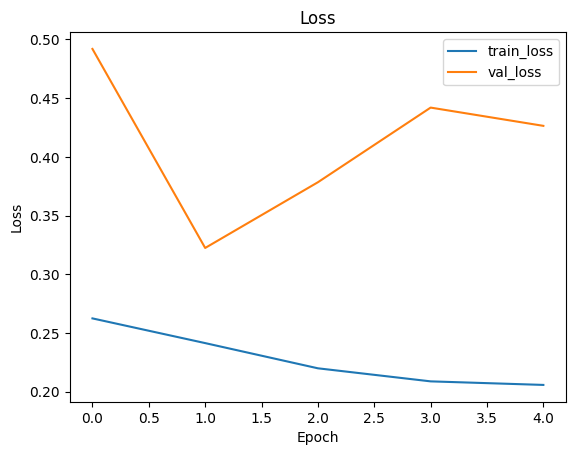

In [ ]:
import matplotlib.pyplot as plt

def plot_history(h):
    # ACCURACY
    plt.figure()
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')
    plt.show()
    # LOSS
    plt.figure()
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
    plt.show()

plot_history(history)


20/20 ━━━━━━━━━━━━━━━━━━━━ 219s 11s/step - accuracy: 0.8935 - loss: 0.3002
Test accuracy: 0.8942  |  Test loss: 0.2717
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.8500    0.8718    0.8608       234
   PNEUMONIA     0.9219    0.9077    0.9147       390

    accuracy                         0.8942       624
   macro avg     0.8859    0.8897    0.8877       624
weighted avg     0.8949    0.8942    0.8945       624



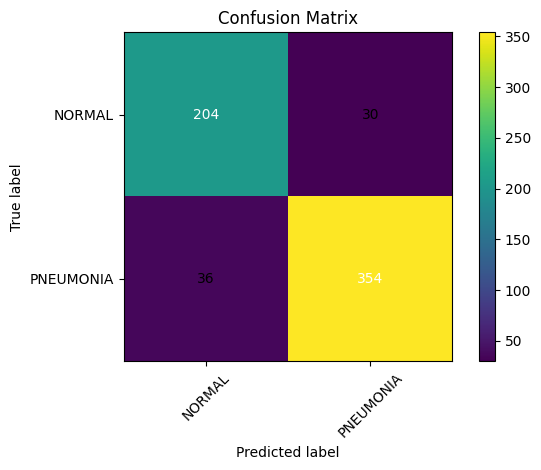

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Load best weights (in case EarlyStopping restored, this is optional)
model.load_weights("/content/drive/MyDrive/ai_project/best_vgg16.h5")

# Raw metrics
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test accuracy: {test_acc:.4f}  |  Test loss: {test_loss:.4f}")

# Predictions → 0/1
test_gen.reset()
probs = model.predict(test_gen, verbose=1).ravel()
y_pred = (probs >= 0.5).astype(int)
y_true = test_gen.classes

# Labels in order of generator
idx_to_class = {v:k for k,v in test_gen.class_indices.items()}
target_names = [idx_to_class[i] for i in sorted(idx_to_class.keys())]

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# Confusion matrix (simple plot)
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
plt.show()


In [ ]:
# Import necessary libraries
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import io # Used to handle image bytes in memory

# ==============================================================================
# IMPORTANT: Make sure your trained model is loaded and available as `model`.
# For example:
# from tensorflow.keras.models import load_model
# model = load_model('path/to/your/pneumonia_model.h5')

# Also, ensure your class names are defined correctly.
# The order must match your model's training data.
# For example, if your model was trained with directories where 'NORMAL' came
# first alphabetically, it would be index 0. Check train_generator.class_indices.
target_names = ['Normal', 'Pneumonia']
# ==============================================================================


# 1. Create the UI widgets
uploader = widgets.FileUpload(
    accept='image/*',
    description='Upload X-Ray',
    multiple=False
)
output_widget = widgets.Output()


# 2. Define the function to handle the upload and make a prediction
def on_upload_change(change):
    """This function runs when a new file is uploaded."""
    # Clear the previous output
    with output_widget:
        clear_output()

        # Check if a file has been uploaded
        if not uploader.value:
            return

        try:
            # Get the content of the uploaded file
            uploaded_file = uploader.value
            filename = next(iter(uploaded_file)) # Get the first (and only) filename
            content = uploaded_file[filename]['content']

            # Use io.BytesIO to read the image from memory
            img = image.load_img(io.BytesIO(content), target_size=(150, 150))

            # Preprocess the image for the model
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) # Create a batch
            img_array /= 255.0 # Rescale pixel values to match training

            # --- Make Prediction ---
            prediction = model.predict(img_array)
            score = prediction[0][0] # Get the raw probability score

            # Interpret the result
            if score < 0.5:
                predicted_class = target_names[0] # Normal
                confidence = 1 - score
            else:
                predicted_class = target_names[1] # Pneumonia
                confidence = score

            # --- Display the results ---
            print(f"✅ Prediction: **{predicted_class}**")
            print(f"Confidence: {confidence:.2%}")

            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred: {e}")

# 3. Link the function to the uploader widget
uploader.observe(on_upload_change, names='value')

# 4. Display the widgets to the user
print("🩺 Please upload a chest X-ray image to get a prediction.")
display(uploader, output_widget)

🩺 Please upload a chest X-ray image to get a prediction.


FileUpload(value={}, accept='image/*', description='Upload X-Ray')

Output()

In [ ]:
# Import necessary libraries
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import io # Used to handle image bytes in memory

# ==============================================================================
# IMPORTANT: Make sure your trained model is loaded and available as `model`.
# For example:
# from tensorflow.keras.models import load_model
# model = load_model('path/to/your/pneumonia_model.h5')

# Also, ensure your class names are defined correctly.
# The order must match your model's training data.
# For example, if your model was trained with directories where 'NORMAL' came
# first alphabetically, it would be index 0. Check train_generator.class_indices.
target_names = ['Normal', 'Pneumonia']
# ==============================================================================


# 1. Create the UI widgets
uploader = widgets.FileUpload(
    accept='image/*',
    description='Upload X-Ray',
    multiple=False
)
output_widget = widgets.Output()


# 2. Define the function to handle the upload and make a prediction
def on_upload_change(change):
    """This function runs when a new file is uploaded."""
    # Clear the previous output
    with output_widget:
        clear_output()

        # Check if a file has been uploaded
        if not uploader.value:
            return

        try:
            # Get the content of the uploaded file
            uploaded_file = uploader.value
            filename = next(iter(uploaded_file)) # Get the first (and only) filename
            content = uploaded_file[filename]['content']

            # Use io.BytesIO to read the image from memory
            img = image.load_img(io.BytesIO(content), target_size=(150, 150))

            # Preprocess the image for the model
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) # Create a batch
            img_array /= 255.0 # Rescale pixel values to match training

            # --- Make Prediction ---
            prediction = model.predict(img_array)
            score = prediction[0][0] # Get the raw probability score

            # Interpret the result
            if score < 0.5:
                predicted_class = target_names[0] # Normal
                confidence = 1 - score
            else:
                predicted_class = target_names[1] # Pneumonia
                confidence = score

            # --- Display the results ---
            print(f"✅ Prediction: **{predicted_class}**")
            print(f"Confidence: {confidence:.2%}")

            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2%}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"An error occurred: {e}")

# 3. Link the function to the uploader widget
uploader.observe(on_upload_change, names='value')

# 4. Display the widgets to the user
print("🩺 Please upload a chest X-ray image to get a prediction.")
display(uploader, output_widget)

🩺 Please upload a chest X-ray image to get a prediction.


FileUpload(value={}, accept='image/*', description='Upload X-Ray')

Output()